In [ ]:
# We shall use RNN to predict stocks
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
# Use pandas to grab Starbucks data (from Feb 2013 to Feb 2018) from Lazy Programmer's GitHub
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [ ]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


If you dont know finance, this can look weird. What are these columns?

Stock market starts early in the morning, stays open for the work day, and then ends

open: price at start of trading day

close: price at end of trading day

high: max price for that day

low: min price for that day

volume: number of shares that were traded that day

remember, all data is the same. we just have to make sure numbers are in the right range for the NN. We may need scaling since some numbers are in the tens and others in the thousands

In [ ]:
df.tail()
# If you invested in starbucks, lucky you, your stock approximately doubled in 5 years

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [ ]:
# Start by doing the WRONG thing, trying to predict the price itself
series = df['close'].values.reshape(-1, 1) # N x 1 (in order to apply sklearn's StandardScaler, hence our data is standardized)

In [ ]:
# Normalize the data
scaler = StandardScaler()
# Get the mean and variance of each of the features (in first half only, to not include test data in training pipeline)
scaler.fit(series[:len(series) // 2])
# Transform ALL the data with the mean and variance just gathered
series = scaler.transform(series).flatten()
# We are stopping in the middle for the true boundary, but in reality its probably a few less/more

In [ ]:
# Build the dataset (no different from sine wave code, except using stock data and not synthetic data)
T = 10 # windows of length 10
D = 1 # target is next value
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [ ]:
# Try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1)
)

r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 9s 27ms/step - loss: 0.1009 - val_loss: 0.0452
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0451
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0062 - val_loss: 0.0253
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0314
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0564
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0744
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0285
Epoch 8/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 0.0223
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0217
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.0259
Epoch 11/80
20/20 [==========

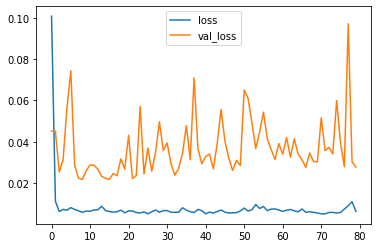

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
# The loss DOES decrease, which is promising (can predict next value somewhat good)

(1249, 1)


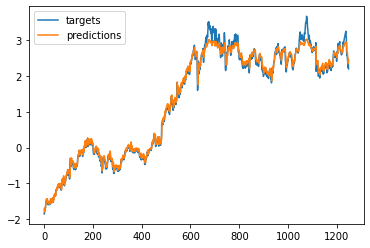

In [ ]:
# One-step forecast
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

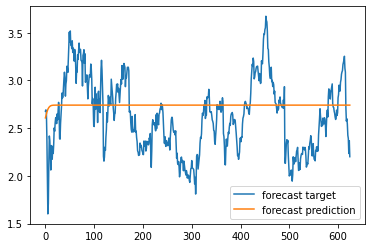

In [ ]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0]
  
  validation_predictions.append(p)

  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
# It's copying the previous value

In [ ]:
# Financial engineers care about the return on investment, not the stock price
# This is (final - initial) / initial
# Calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # new column
# Now its like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# ...
# x[t] x[t-1]

In [ ]:
df.head()
# NaN on PrevClose for first row
# As long as first row is not in target, we're fine

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [ ]:
# New 'return' column = (x[t] - x[t-1]) / x[t-1]
df['return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


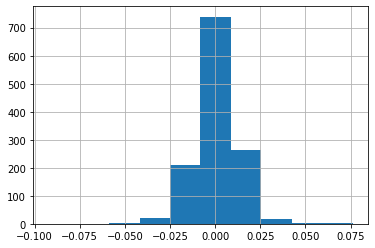

In [ ]:
# Now try an LSTM to predict returns
df['return'].hist() # distribution of returns (small values, might want to normalize)

In [ ]:
# values at 1 and up since index 0 has NaN
series = df['return'].values[1:].reshape(-1, 1) # N x 1

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [ ]:
# Same procedure as before (but for returns and not stock price)
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)

In [ ]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1)
)

r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 2s 26ms/step - loss: 1.0224 - val_loss: 1.1593
Epoch 2/80
20/20 [==============================] - 0s 8ms/step - loss: 1.0060 - val_loss: 1.1529
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9910 - val_loss: 1.1546
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9985 - val_loss: 1.2033
Epoch 5/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9823 - val_loss: 1.1801
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9847 - val_loss: 1.1667
Epoch 7/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9804 - val_loss: 1.1469
Epoch 8/80
20/20 [==============================] - 0s 8ms/step - loss: 1.0002 - val_loss: 1.1626
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9771 - val_loss: 1.2559
Epoch 10/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9830 - val_loss: 1.1882
Epoch 11/80
20/20 [==========

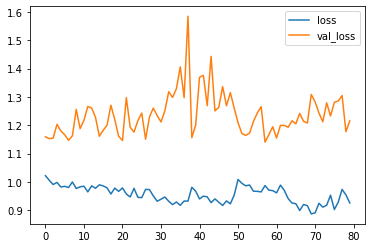

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
# Model has a harder time learning anything (fits to noise)

(1248, 1)


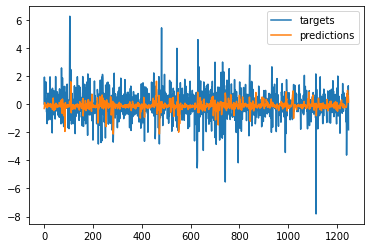

In [ ]:
# One-step forecast
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

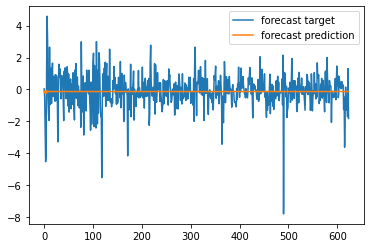

In [ ]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0]
  
  validation_predictions.append(p)

  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
# Again, copies same value over and over again

In [ ]:
# The proper model involves using all the data (D = 5) and predicting whether price will go up or down (binary classification)
# Turn data into numpy arrays. Targets are the return values
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['return'].values

In [ ]:
print(input_data.shape)

(1259, 5)


In [ ]:
# Make the data to go into the NN
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [ ]:
# Normalize the inputs (especially important since volume column is so high)
# First 2/3 is train set, last 1/3 is test set
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [ ]:
# Create train set
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [ ]:
# Create test set
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain) (indexes our current test arrays)
  # t counts from Ntrain...N (indexes original dataset)
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [ ]:
# Make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
# Training loss goes down but validation loss goes up -> overfitting to noise

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
# Test accuracy stays at 50% because in binary classification, 0 accuracy is not the worst, instead 50 is

So, because its nearly impossible to accurately predict whether stock price will go up/down, itll be even harder to predict stock returns

Also, stocks are driven by real-world events, and its insane to predict stocks given historical data, because its not deterministic

More realistically, it may be more sensible to look at emotions of investors, how companies are portrayed in media, new inventions, etc.

Proper stock prediction may perhaps involve a lifetime worth of study

Stock prices follow a random walk. A naive forecast, which predicts the last value, is the best forecast, so it should be used as a baseline model you would use to compare against your more complex model